# Project - Second Requirement

### Include packages.

In [3]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import norm
from itertools import product
from scipy.optimize import linprog

### The first thing to do is to code the environment.

In [4]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [5]:
class PricingEnvironmentMultiProduct(Environment):
    def __init__(self, costs, mean_valuations, std_valuations, buyers_per_round):
        self.N = len(costs)
        self.costs = np.array(costs)
        self.mean_valuations = np.array(mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round

    def round(self, prices):
        sales_per_product = np.zeros(self.N)
        rewards_per_product = np.zeros(self.N)

        for i in range(self.N):
            p_t = prices[i]
            prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuations[i], scale=self.std_valuations[i])
            num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
            reward_i = (p_t - self.costs[i]) * num_sales

            sales_per_product[i] = num_sales
            rewards_per_product[i] = reward_i

        total_reward = np.sum(rewards_per_product)
        total_sales = np.sum(sales_per_product)
        return sales_per_product, total_reward, rewards_per_product

### Now define the setting...

In [37]:
# --- Global Settings ---

N = 5                       # Number of products
T = 20000 * N               # Time horizon (number of rounds)
n_trials = 10               # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

price_step = 0.5

K = 5         # Number of price options (arms per product)

costs = np.array([2.00, 1.50, 2.50, 0.50, 4.00])
values = np.array([3.00, 2.50, 3.00, 1.50, 6.00])
std_valuations = np.array([1.0, 0.8, 1.2, 0.5, 1.5])

assert len(costs) == len(values) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert np.all(costs < values), "Each product's cost must be less than its corresponding value"

# --- Build per-product price grids ---
price_grids = []
for i in range(N):
    p_min = 0.5 * costs[i]
    p_max = values[i] * 2
    custom_prices = np.linspace(p_min, p_max, 5)
    price_grids.append(custom_prices)

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory (shared among all products)

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom = 0.001              # Zoom factor for plotting
s = 32                   # random seed

### Expected demand and profit using theoretical expectations.

In [7]:
# --- Initialize matrices for expected demand/profit ---
expected_demand_matrix = []
expected_profit_matrix = []

for i in range(N):
    prices = price_grids[i]
    demands = []
    profits = []
    for p in prices:
        prob_buy = 1 - norm.cdf(p, loc=values[i], scale=std_valuations[i])
        expected_demand = buyers_per_round * prob_buy
        expected_profit = (p - costs[i]) * expected_demand
        demands.append(expected_demand)
        profits.append(expected_profit)
    expected_demand_matrix.append(demands)
    expected_profit_matrix.append(profits)

expected_demand_matrix = np.array(expected_demand_matrix)
expected_profit_matrix = np.array(expected_profit_matrix)

# --- Find best price per product ---
best_price_indices = np.argmax(expected_profit_matrix, axis=1)
best_prices = np.array([price_grids[i][idx] for i, idx in enumerate(best_price_indices)])
best_profits = expected_profit_matrix[np.arange(N), best_price_indices]

# --- Summary ---
print("=== Best Expected Prices ===")
for i in range(N):
    print(f"Product {i}: optimal price = €{best_prices[i]:.2f}, expected profit = €{best_profits[i]:.2f}")

=== Best Expected Prices ===
Product 0: optimal price = €3.50, expected profit = €23.14
Product 1: optimal price = €2.88, expected profit = €21.97
Product 2: optimal price = €3.62, expected profit = €16.94
Product 3: optimal price = €1.62, expected profit = €22.57
Product 4: optimal price = €7.00, expected profit = €37.87


### Let us visualize our setting.

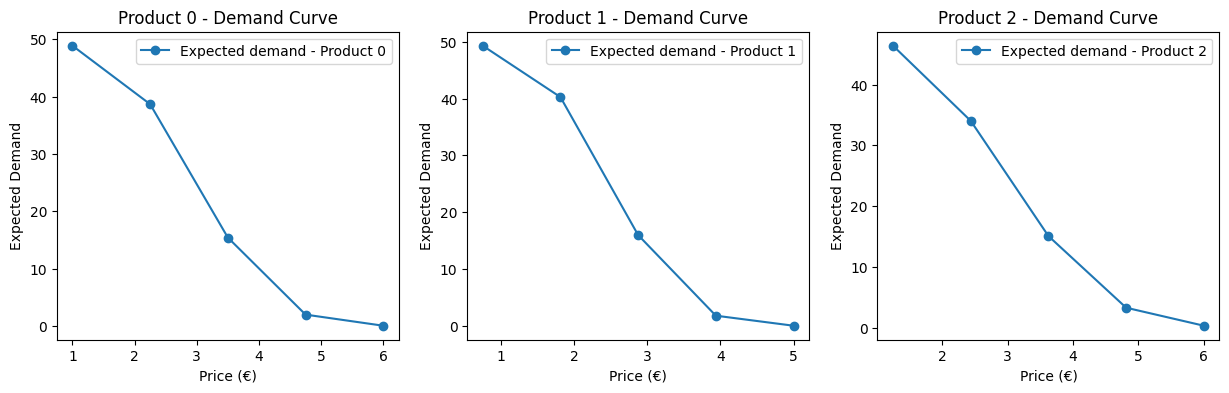

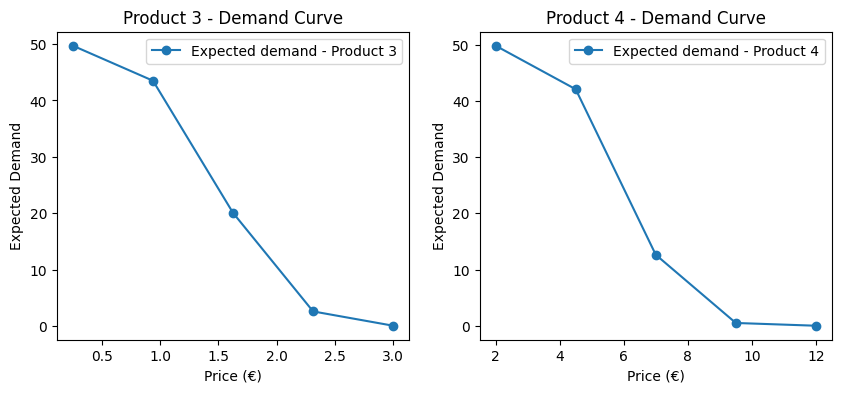

In [8]:
# --- Visualization ---

fig1, axs1 = plt.subplots(1, 3, figsize=(15, 4))
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 4))

# Plot items 1, 2 and 3
for i in range(min(N, 3)):
    axs1[i].plot(price_grids[i], expected_demand_matrix[i], label=f'Expected demand - Product {i}', marker='o')
    axs1[i].set_title(f"Product {i} - Demand Curve")
    axs1[i].set_xlabel("Price (€)")
    axs1[i].set_ylabel("Expected Demand") # Y-axis will naturally be float if expected_demand_matrix[i] contains floats
    axs1[i].legend()

# Plot items 4 and 5
for i in range(3, min(N, 5)):
    axs2[i-3].plot(price_grids[i], expected_demand_matrix[i], label=f'Expected demand - Product {i}', marker='o')
    axs2[i-3].set_title(f"Product {i} - Demand Curve")
    axs2[i-3].set_xlabel("Price (€)")
    axs2[i-3].set_ylabel("Expected Demand") # Y-axis will naturally be float if expected_demand_matrix[i] contains floats
    axs2[i-3].legend()

### Agent

In [9]:
class GlobalLinearProgramUCB:
    def __init__(self, N, K, B, T, price_grids, scale=1.0):
        self.N = N
        self.K = K
        self.B = B
        self.T = T
        self.scale = scale
        self.price_grids = price_grids
        self.rho = B / T
        self.t = 0
        self.inventory = B

        # All possible actions = super-arms (as tuples of price indices)
        self.actions = list(product(range(K), repeat=N))
        self.A = len(self.actions)

        # To estimate rewards and consumption
        self.avg_rewards = np.zeros(self.A)
        self.avg_sales = np.zeros(self.A)
        self.N_pulls = np.zeros(self.A)

        self.last_action_idx = None

    def pull_arm(self):
        if self.inventory < 1:
            self.last_action_idx = None
            return None

        if self.t < self.A:
            action_idx = self.t
        else:
            ucb = self.avg_rewards + self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, self.N_pulls))
            lcb = self.avg_sales - self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, self.N_pulls))
            action_idx = self.solve_lp(ucb, lcb)

        self.last_action_idx = action_idx

        return self.actions[action_idx]

    def solve_lp(self, ucb_rewards, lcb_sales):
        # Solve: max sum(gamma[a] * ucb[a]) s.t. sum(gamma[a] * lcb[a]) <= rho, sum gamma = 1
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            return np.argmax(ucb_rewards)

    def update(self, sales, total_reward):
        if self.last_action_idx is None:
            return

        idx = self.last_action_idx
        self.N_pulls[idx] += 1
        self.avg_rewards[idx] += (total_reward - self.avg_rewards[idx]) / self.N_pulls[idx]
        self.avg_sales[idx] += (np.sum(sales) - self.avg_sales[idx]) / self.N_pulls[idx]
        self.inventory -= np.sum(sales)
        self.t += 1

### Run

We waste so many products in the exploration phase!

STOP: Empty inventory at round 46643


Text(0.5, 1.0, 'Inventory consumption')

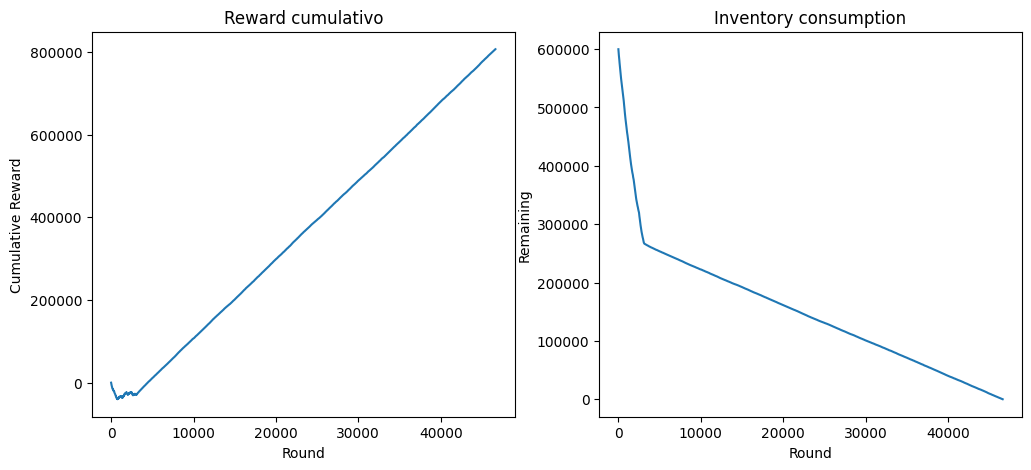

In [38]:
# --- Setup random seed ---
np.random.seed(s)

# --- Init ---
env = PricingEnvironmentMultiProduct(
    costs=costs,
    mean_valuations=values,
    std_valuations=std_valuations,
    buyers_per_round=buyers_per_round
)

agent = GlobalLinearProgramUCB(N, K, B, T, price_grids, scale = 1)

# --- To log ---
rewards_over_time = []
inventory_left = []
regret_over_time = []


# --- Run ---
for t in range(T):

    a_t = agent.pull_arm()

    if a_t is None:
        print(f"STOP: Empty inventory at round {t}")
        break

    prices = [price_grids[i][a_t[i]] for i in range(N)]
    sales, total_reward, rewards_per_product = env.round(prices)
    agent.update(sales, total_reward)

    # Log
    rewards_over_time.append(total_reward)
    inventory_left.append(agent.inventory)

    #Calculate the istant regret as the sum of best profits - current profit
    istant_regret = np.sum(best_profits) - total_reward
    regret_over_time.append(istant_regret)

# --- To plot ---
rewards_over_time = np.array(rewards_over_time)
cumulative_reward = np.cumsum(rewards_over_time)
cumulative_regret = np.cumsum(regret_over_time)

# --- Plot ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_reward)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Reward cumulativo")

plt.subplot(1, 2, 2)
plt.plot(inventory_left)
plt.xlabel("Round")
plt.ylabel("Remaining")
plt.title("Inventory consumption")

Text(0.5, 1.0, 'Regret Istantaneo')

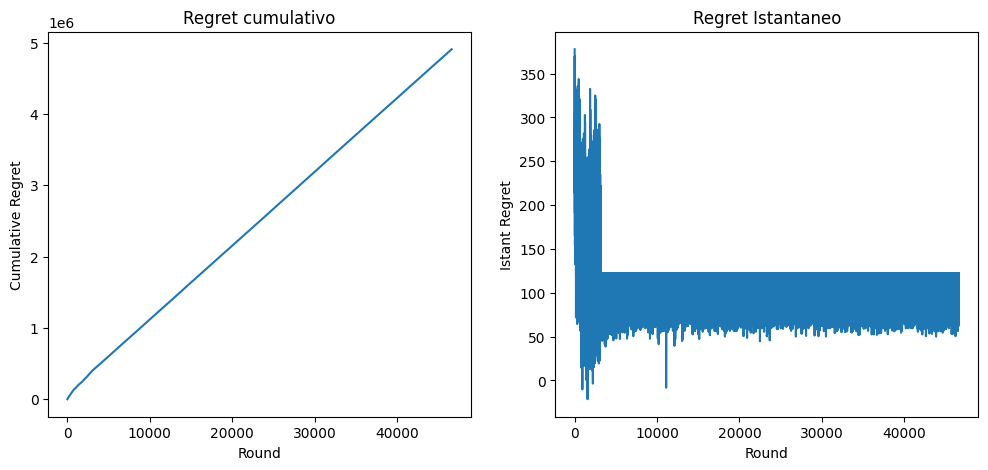

In [42]:
plt.figure(figsize=(12, 5))

avg_regret = np.array(regret_over_time).mean(axis = 0)
regret_sd = np.array(regret_over_time).std(axis=0)

plt.subplot(1, 2, 1)
plt.plot(cumulative_regret)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Regret cumulativo")


plt.subplot(1, 2, 2)
plt.plot(regret_over_time)
plt.xlabel("Round")
plt.ylabel("Istant Regret")
plt.title("Regret Istantaneo")